### Pair Trading 활용
- 100개의 종목 데이터를 추출

#### 1) 데이터 가져오기
- 상장 종목별 시계열데이터를 생성
- FinanceDataReader 모듈을 사용
- 종목별로 생성되어 있는 일자가 상이해 KOSPI 지수 데이터를 기준으로 삼고 종목별 시계열 데이터를 맞추고자 함

In [1]:
import numpy as np
import pandas as pd
import statsmodels
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt
np.random.seed(42)

In [2]:
import FinanceDataReader as fdr

print(fdr.__version__)

0.9.50


In [3]:
df_krx = fdr.StockListing('KRX')

df_kospi = fdr.StockListing('KOSPI')
df_kosdoq = fdr.StockListing('KOSDAQ')
df_konex = fdr.StockListing('KONEX')

print('krx count    :', df_krx['Code'].count())
print('kospi count  :', df_kospi['Code'].count())
print('kosdoq count :', df_kosdoq['Code'].count())
print('konex count  :', df_konex['Code'].count())

krx count    : 2665
kospi count  : 940
kosdoq count : 1599
konex count  : 126


In [4]:
df_krx.columns

Index(['Code', 'ISU_CD', 'Name', 'Market', 'Dept', 'Close', 'ChangeCode',
       'Changes', 'ChagesRatio', 'Open', 'High', 'Low', 'Volume', 'Amount',
       'Marcap', 'Stocks', 'MarketId'],
      dtype='object')

In [5]:
# 한국거래소 상장종목 전체
# 용도 : 코드와 종목명 가져오기
df_krx = fdr.StockListing('KRX')
df_krx.head()

Code        ISU_CD      Name Market Dept   Close ChangeCode  Changes  \
0  005930  KR7005930003      삼성전자  KOSPI        59700          1      300   
1  373220  KR7373220003  LG에너지솔루션  KOSPI       557000          1    29000   
2  207940  KR7207940008  삼성바이오로직스  KOSPI       879000          1     2000   
3  000660  KR7000660001    SK하이닉스  KOSPI        83100          1      400   
4  006400  KR7006400006     삼성SDI  KOSPI       758000          1    21000   

   ChagesRatio    Open    High     Low    Volume        Amount  \
0         0.51   59900   60300   59500  14096355  844449064900   
1         5.49  534000  558000  533000    401696  220167794000   
2         0.23  886000  887000  874000     40497   35624011000   
3         0.48   82700   83600   81400   2944230  243750640100   
4         2.85  735000  759000  732000    335719  249961360000   

            Marcap      Stocks MarketId  
0  356396018235000  5969782550      STK  
1  130338000000000   234000000      STK  
2   62561946000000    71174000      STK  
3   60496996531500   728002365      STK  
4   52123513740000    68764530      STK

In [6]:
df_krx.columns

Index(['Code', 'ISU_CD', 'Name', 'Market', 'Dept', 'Close', 'ChangeCode',
       'Changes', 'ChagesRatio', 'Open', 'High', 'Low', 'Volume', 'Amount',
       'Marcap', 'Stocks', 'MarketId'],
      dtype='object')

- 임시로 10개 종목만 분석
- 시작일과 종료일은 5개년 데이터를 사용

In [7]:
n = 20 # 생성할 종목수 지정
df_krx_list = df_krx['Code'].head(n*2) # 임시로 2배까지 루프
df_krx_list

0     005930
1     373220
2     207940
3     000660
4     006400
5     051910
6     005935
7     005380
8     035420
9     000270
10    068270
11    035720
12    028260
13    005490
14    012330
15    105560
16    055550
17    096770
18    034730
19    003670
20    032830
21    066570
22    003550
23    033780
24    010130
25    086790
26    247540
27    015760
28    017670
29    091990
30    034020
31    010950
32    329180
33    018260
34    000810
35    009830
36    030200
37    011200
38    009150
39    259960
Name: Code, dtype: object

In [8]:
# 코스피 종목 추출
# 용도 : DataReader 사용시 종목별 기간 조회 건수가 상이
#        코스피 데이터 날짜를 기준으로 가져오기 위해 사용
strt_dt = '2017-01-01' # 시작일 지정
end_dt = '2021-12-31'  # 종료일 지정
kospi_df = fdr.DataReader('KS11', strt_dt,end_dt)
kospi_df.reset_index(inplace = True)
kospi_df.head()

Date         Open         High          Low        Close    Adj Close  \
0 2017-01-02  2022.229980  2031.790039  2015.680054  2026.160034  2026.160034   
1 2017-01-03  2034.310059  2044.069946  2028.469971  2043.969971  2043.969971   
2 2017-01-04  2046.290039  2046.290039  2040.609985  2045.640015  2045.640015   
3 2017-01-05  2045.520020  2046.500000  2039.489990  2041.949951  2041.949951   
4 2017-01-06  2048.110107  2051.840088  2045.660034  2049.120117  2049.120117   

   Volume  
0  229900  
1  268100  
2  371500  
3  541300  
4  455400

In [9]:
stock_df = pd.DataFrame()
stock_df['Date'] = kospi_df['Date']
print("동기간 KOSPI 생성일수 : ", len(kospi_df['Date']))
normal_cnt = 0
err_cnt = 0


for code in df_krx_list:
    stock = df_krx[df_krx.Code == code]
    code_nm = list(stock.Name)[0]


    try:
        temp = fdr.DataReader(code, strt_dt, end_dt)

        # 데이터일수가 시장보다 작으면 skip(최근 상장 데이터로 판단)
        if len(temp) < len(kospi_df['Date']):
            err_cnt += 1
            print("skip : (",err_cnt,")", code, code_nm, strt_dt, end_dt, ", 건수 : ", len(temp))
            continue

        temp.reset_index(inplace = True)
        temp_df = pd.merge(temp[['Date','Close']], kospi_df[['Date']], on='Date', how='right')
        stock_df[code_nm] = temp_df.Close

        normal_cnt += 1
        print("정상 : (",normal_cnt,")", code, code_nm, strt_dt, end_dt, ", 건수 : ", len(temp), "->", len(stock_df))
    except:
        err_cnt += 1
        print("skip : (",err_cnt,")", code, code_nm, strt_dt, end_dt, ", 건수 : ", len(temp))

    if normal_cnt == n:
        print('총', n,'개 생성 설정 / ', normal_cnt, '개 생성 완료')
        break # n개 종목 생성시 종료

동기간 KOSPI 생성일수 :  1227
정상 : ( 1 ) 005930 삼성전자 2017-01-01 2021-12-31 , 건수 :  1229 -> 1227
skip : ( 1 ) 373220 LG에너지솔루션 2017-01-01 2021-12-31 , 건수 :  0
정상 : ( 2 ) 207940 삼성바이오로직스 2017-01-01 2021-12-31 , 건수 :  1229 -> 1227
정상 : ( 3 ) 000660 SK하이닉스 2017-01-01 2021-12-31 , 건수 :  1229 -> 1227
정상 : ( 4 ) 006400 삼성SDI 2017-01-01 2021-12-31 , 건수 :  1229 -> 1227
정상 : ( 5 ) 051910 LG화학 2017-01-01 2021-12-31 , 건수 :  1229 -> 1227
정상 : ( 6 ) 005935 삼성전자우 2017-01-01 2021-12-31 , 건수 :  1229 -> 1227
정상 : ( 7 ) 005380 현대차 2017-01-01 2021-12-31 , 건수 :  1229 -> 1227
정상 : ( 8 ) 035420 NAVER 2017-01-01 2021-12-31 , 건수 :  1229 -> 1227
정상 : ( 9 ) 000270 기아 2017-01-01 2021-12-31 , 건수 :  1229 -> 1227
정상 : ( 10 ) 068270 셀트리온 2017-01-01 2021-12-31 , 건수 :  1229 -> 1227
정상 : ( 11 ) 035720 카카오 2017-01-01 2021-12-31 , 건수 :  1229 -> 1227
정상 : ( 12 ) 028260 삼성물산 2017-01-01 2021-12-31 , 건수 :  1229 -> 1227
정상 : ( 13 ) 005490 POSCO홀딩스 2017-01-01 2021-12-31 , 건수 :  1229 -> 1227
정상 : ( 14 ) 012330 현대모비스 2017-01-01 2021-12-3

In [10]:
stock_df.head()

Date   삼성전자  삼성바이오로직스  SK하이닉스   삼성SDI    LG화학  삼성전자우     현대차   NAVER  \
0 2017-01-02  36100    154668   45800  106000  253000  28800  150000  155620   
1 2017-01-03  36480    156151   47250  110000  262000  28780  153000  153617   
2 2017-01-04  36160    152692   46500  108500  268500  28800  154000  162230   
3 2017-01-05  35560    155657   46950  112000  267500  28280  153500  158424   
4 2017-01-06  36200    155657   48000  113000  266000  28620  151000  160026   

      기아  ...    카카오    삼성물산  POSCO홀딩스   현대모비스   KB금융   신한지주  SK이노베이션      SK  \
0  39500  ...  15394  125500    260500  271500  42600  45300   147000  230000   
1  40750  ...  16057  129000    256000  275500  43700  46450   155000  229000   
2  41300  ...  16920  129000    254500  276000  44150  47000   156000  227000   
3  41100  ...  16860  128000    247500  280500  42800  45100   154000  233000   
4  40750  ...  16800  129000    250000  272500  42650  45300   157000  232500   

   포스코케미칼    삼성생명  
0   11263  110000  
1   11028  110000  
2   11357  113000  
3   11357  113500  
4   11544  112500  

[5 rows x 21 columns]

#### 2) 데이터 정리
- 편의를 위해 오름차순 정렬 및 인덱스를 설정하고, 있을지 모를 결측치를 전일 데이터로 채움
- 공적분에 사용할 data는 종가 자체 데이터를 사용

In [11]:
# 데이터 정렬
stock_df.sort_values('Date', ascending=True, inplace=True) # ascending=True 오름차순, False 내림차순
# 결측치 채우기
stock_df.fillna(method='ffill', inplace=True)
# 인덱스 설정
stock_df.set_index('Date', inplace=True)
data = stock_df
data.head()

삼성전자  삼성바이오로직스  SK하이닉스   삼성SDI    LG화학  삼성전자우     현대차   NAVER  \
Date                                                                         
2017-01-02  36100    154668   45800  106000  253000  28800  150000  155620   
2017-01-03  36480    156151   47250  110000  262000  28780  153000  153617   
2017-01-04  36160    152692   46500  108500  268500  28800  154000  162230   
2017-01-05  35560    155657   46950  112000  267500  28280  153500  158424   
2017-01-06  36200    155657   48000  113000  266000  28620  151000  160026   

               기아   셀트리온    카카오    삼성물산  POSCO홀딩스   현대모비스   KB금융   신한지주  \
Date                                                                      
2017-01-02  39500  97761  15394  125500    260500  271500  42600  45300   
2017-01-03  40750  96316  16057  129000    256000  275500  43700  46450   
2017-01-04  41300  95864  16920  129000    254500  276000  44150  47000   
2017-01-05  41100  96135  16860  128000    247500  280500  42800  45100   
2017-01-06  40750  95142  16800  129000    250000  272500  42650  45300   

            SK이노베이션      SK  포스코케미칼    삼성생명  
Date                                         
2017-01-02   147000  230000   11263  110000  
2017-01-03   155000  229000   11028  110000  
2017-01-04   156000  227000   11357  113000  
2017-01-05   154000  233000   11357  113500  
2017-01-06   157000  232500   11544  112500

#### 3) 공적분 함수 정의

In [12]:
# p-value가 지정된 값보다 작은 pair 쌍을 반환한다.
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    all_pairs = []
    pairs = []

    # result
    stock1 = []
    stock2 = []
    pvalue_list = []
    check_95 = []
    check_98 = []

    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue


            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
                check_95.append('Y')
            else:
                check_95.append('N')

            if pvalue < 0.02:
                check_98.append('Y')
            else:
                check_98.append('N')

            # result
            stock1.append(keys[i])
            stock2.append(keys[j])
            pvalue_list.append(pvalue)


    pair_pvalue = pd.DataFrame()
    pair_pvalue['s1'] = stock1
    pair_pvalue['s2'] = stock2
    pair_pvalue['pvalue'] = pvalue_list
    pair_pvalue['check_95'] = check_95
    pair_pvalue['check_98'] = check_98

    pair_pvalue.sort_values('pvalue', ascending=True, inplace=True) # ascending=True 오름차순

    return score_matrix, pvalue_matrix, pair_pvalue, pairs

#### 4) HeatMap 그래프 

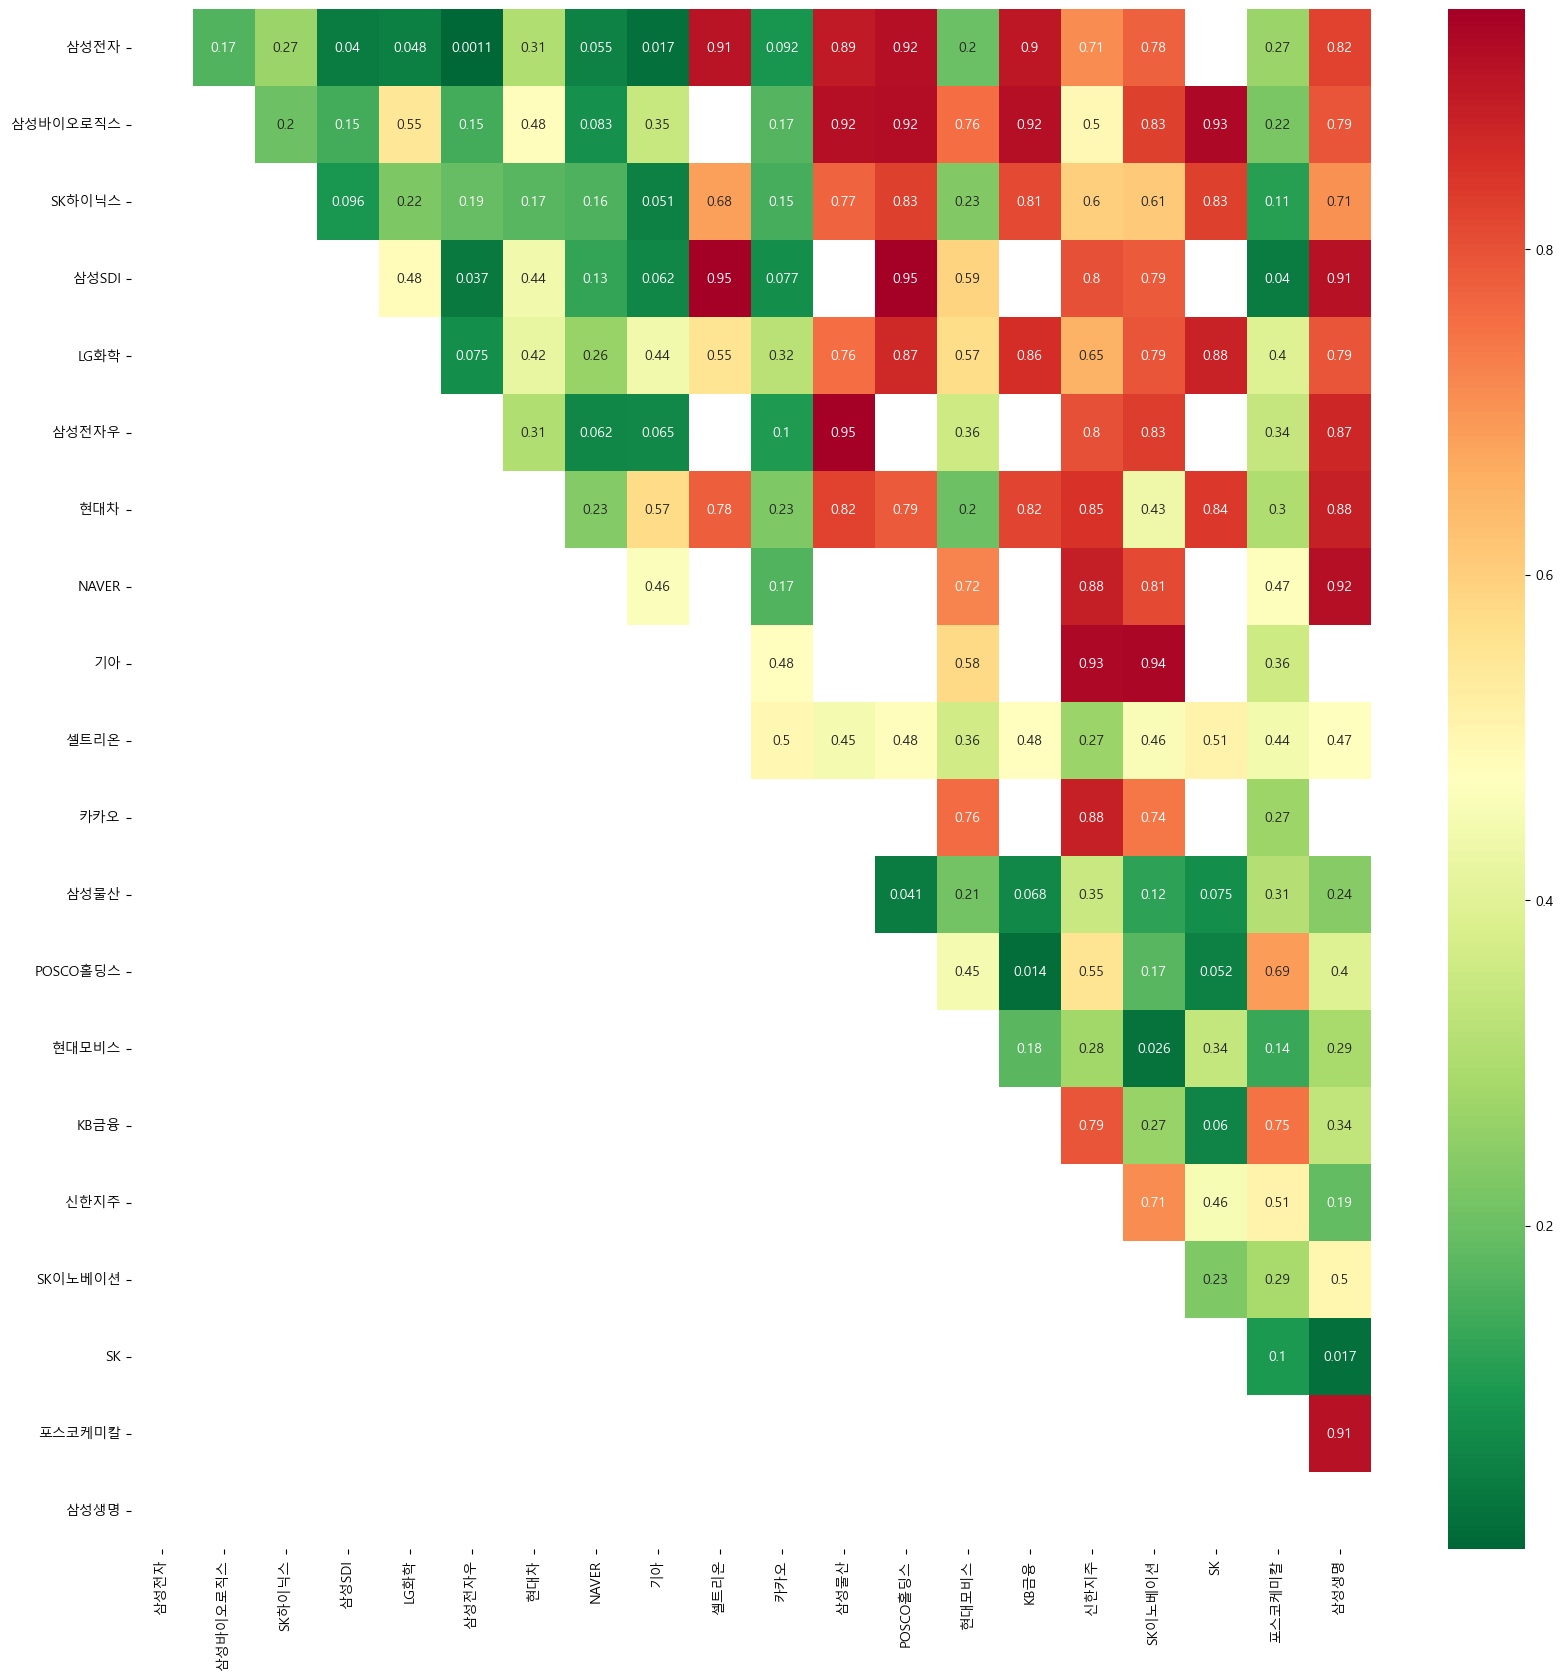

[('삼성전자', '삼성SDI'), ('삼성전자', 'LG화학'), ('삼성전자', '삼성전자우'), ('삼성전자', '기아'), ('삼성SDI', '삼성전자우'), ('삼성SDI', '포스코케미칼'), ('삼성물산', 'POSCO홀딩스'), ('POSCO홀딩스', 'KB금융'), ('현대모비스', 'SK이노베이션'), ('SK', '삼성생명')]


In [13]:
plt.rc('font', family='Malgun Gothic')
plt.figure(figsize=(20,20))
# Heatmap
instrumentIds = list(data.columns.values)

scores, pvalues, pair_pvalue, pairs = find_cointegrated_pairs(data)
import seaborn
m = [0,0.2,0.4,0.6,0.8,1]
seaborn.heatmap(pvalues, xticklabels=instrumentIds,
                yticklabels=instrumentIds, cmap='RdYlGn_r', annot=True,
                mask = (pvalues >= 0.95))
plt.show()

# 유의한 pair 출력
print(pairs)

In [14]:
# pvalue < 0.05 인 항목 출력
pair_pvalue[pair_pvalue.pvalue<0.05]

s1        s2    pvalue check_95 check_98
4        삼성전자     삼성전자우  0.001084        Y        Y
163  POSCO홀딩스      KB금융  0.013514        Y        Y
7        삼성전자        기아  0.016696        Y        Y
188        SK      삼성생명  0.017386        Y        Y
171     현대모비스   SK이노베이션  0.025664        Y        N
55      삼성SDI     삼성전자우  0.036691        Y        N
68      삼성SDI    포스코케미칼  0.039669        Y        N
2        삼성전자     삼성SDI  0.040252        Y        N
154      삼성물산  POSCO홀딩스  0.040669        Y        N
3        삼성전자      LG화학  0.048185        Y        N

#### 5) 트레이딩 전략 수립
- Step 1 : Setup problem
    - 종목1의 주가를 S1, 종목2를 S2로 두고 아래와 같이 Ratio 비율을 계산
    - Ratio = S1/S2 Ratio 비율은 S1 1개당 S2의 수량을 의미
    - 매수 신호(-1이하) 포착시, S1을 n개 매수하고, S2를 n * Ratio개 매도
    - 매도 신호(+1이상) 포착시, S1을 n개 매도하고, S2를 n * Ratio개 매수
- Step 2: Collect Reliable and Accurate Data
    - 트레이딩 전략을 세울 Pair 셋팅

In [15]:
# 현대모비스	SK이노베이션 2개 종목 추출
s1_nm = '현대모비스'
s2_nm = 'SK이노베이션'
S1 = data[s1_nm]
S2 = data[s2_nm]
S1, S2

(Date
 2017-01-02    271500
 2017-01-03    275500
 2017-01-04    276000
 2017-01-05    280500
 2017-01-06    272500
                ...  
 2021-12-24    263000
 2021-12-27    261500
 2021-12-28    265500
 2021-12-29    261000
 2021-12-30    254500
 Name: 현대모비스, Length: 1227, dtype: int64,
 Date
 2017-01-02    147000
 2017-01-03    155000
 2017-01-04    156000
 2017-01-05    154000
 2017-01-06    157000
                ...  
 2021-12-24    223500
 2021-12-27    224000
 2021-12-28    226000
 2021-12-29    239000
 2021-12-30    238500
 Name: SK이노베이션, Length: 1227, dtype: int64)

-  Step 3: Split Data
    - 검증을 위해 7:3 비율로 Train:Test 셋 분리

In [16]:
ratios = S1 / S2
cut = int(len(ratios)*0.7)
train = ratios[:cut]
test = ratios[cut:]

S1_train = S1.iloc[:cut]
S2_train = S2.iloc[:cut]
S1_test = S1.iloc[cut:]
S2_test = S2.iloc[cut:]

- Step 4: Feature Engineering

    - 다음과 같은 요소들에 의해 매도/매수 신호를 포착
        - 60 day Moving Average of Ratio: Measure of rolling mean
        - 5 day Moving Average of Ratio: Measure of current value of mean
        - 60 day Standard Deviation
        - z score: (5d MA — 60d MA) /60d SD

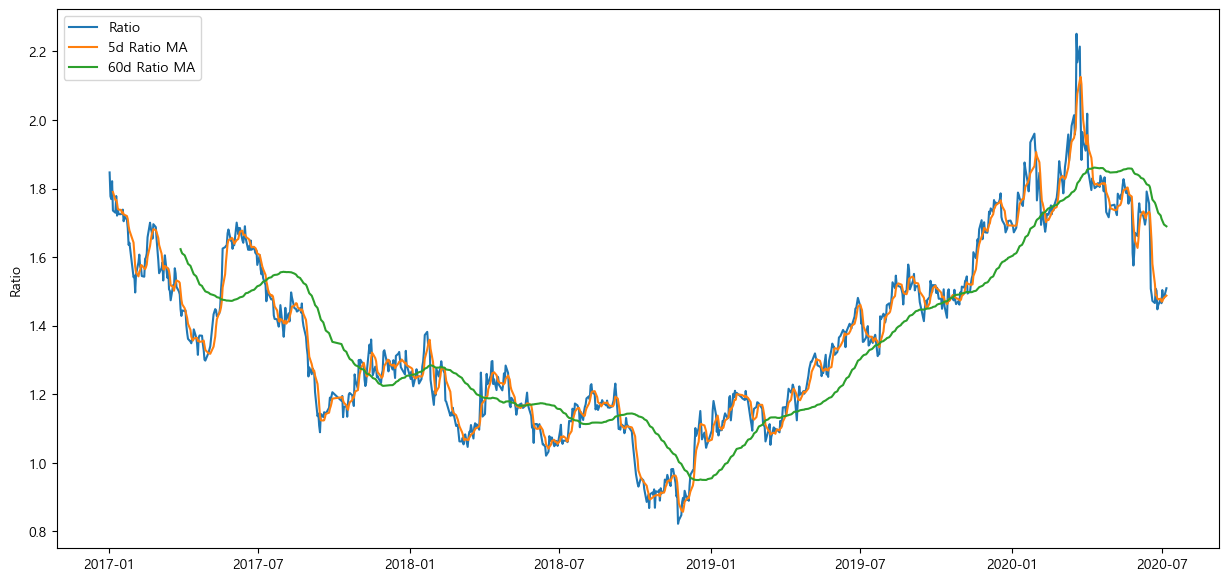

In [17]:
ratios_mavg5 = train.rolling(window=5,
                               center=False).mean()
ratios_mavg60 = train.rolling(window=60,
                               center=False).mean()
std_60 = train.rolling(window=60,
                        center=False).std()
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
plt.figure(figsize=(15,7))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)
plt.legend(['Ratio','5d Ratio MA', '60d Ratio MA'])
plt.ylabel('Ratio')
plt.show()

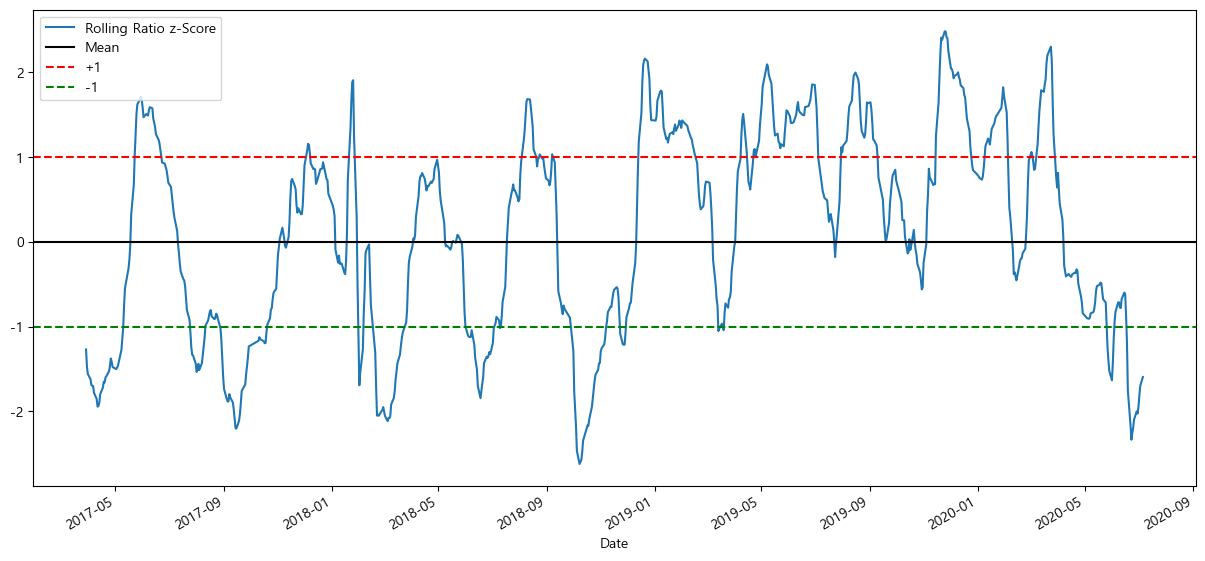

In [18]:
# 음수 처리
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(15,7))
zscore_60_5.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

- 최근 5일 이평선과 60일 이평선(평균)으로 산출한 Z-score를 그래프로 확인
- 대부분 -1~1사이에 위치해 있으며 평균으로 회귀하려는 경향을 확인

- Step 5: Model Selection
    - Z-score가 -1이하로 떨어지면 S1매수&S2매도하고 +1이상 오르면 S1매도&S2매수
- Step 6: Train, Validate and Optimize
    - 모델이 수행하는 액션을 그래프로 확인

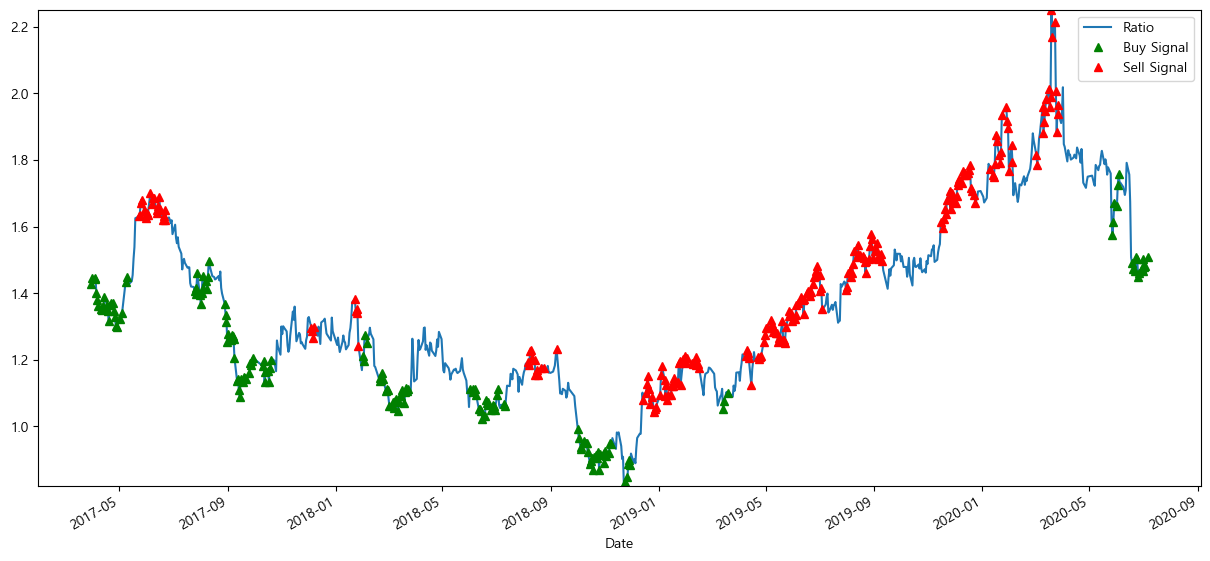

In [19]:
# Plot the ratios and buy and sell signals from z score
plt.figure(figsize=(15,7))
train[60:].plot()
buy = train.copy()
sell = train.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
buy[60:].plot(color='g', linestyle='None', marker='^')
sell[60:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,ratios.min(),ratios.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

---
### 실전 트레이딩 전략
- 셋팅된 기준은 Z-score를 기준으로
    - +1 이상일 경우 : S1 n개 매도, S2 n * ratio 매수
    - -1 이하일 경우 : S1 n개 매수, S2 n * ratio 매도
    - -0.5 ~ 0.5 사이이면서 현재 수익(+)을 내고 있을 경우, 포지션 정리하여 이익을 실현한다.
---

In [20]:
# 간단한 전력을 이용한 트레이딩
def trade(S1, S2, window1, window2):

    # window 길이가 0이면 알고리즘이 의미가 없으므로 종료
    if (window1 == 0) or (window2 == 0):
        return 0

    # 롤링 평균 및 롤링 표준 편차 계산
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std

    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] > 1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
            print('Selling Ratio %s %s %s %s'%(money, ratios[i], countS1,countS2))
        # Buy long if the z-score is < 1
        elif zscore[i] < -1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
            print('Buying Ratio %s %s %s %s'%(money,ratios[i], countS1,countS2))
        # Clear positions if the z-score between -.5 and .5
        # -0.5~0.5 사이인 경우 수익일 경우 이익 실현
        elif abs(zscore[i]) < 0.5 and (money + S1[i] * countS1 + S2[i] * countS2) > 0 :
            money += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0
            countS2 = 0
            print('Exit pos %s %s %s %s'%(money,ratios[i], countS1,countS2))


    return money

In [21]:
# 시뮬레이션
money = trade(S1_train, S2_train, 100, 10)
money

Buying Ratio 0.0 1.6480938416422288 1 -1.6480938416422288
Buying Ratio 0.0 1.6242603550295858 2 -3.272354196671815
Buying Ratio 0.0 1.6396396396396395 3 -4.911993836311455
Buying Ratio 0.0 1.634441087613293 4 -6.546434923924748
Buying Ratio 0.0 1.7006172839506173 5 -8.247052207875365
Buying Ratio 0.0 1.6666666666666667 6 -9.913718874542031
Buying Ratio 0.0 1.6847133757961783 7 -11.59843225033821
Buying Ratio 0.0 1.6847133757961783 8 -13.283145626134388
Buying Ratio 0.0 1.6489028213166144 9 -14.932048447451002
Buying Ratio 0.0 1.6417445482866044 10 -16.573792995737605
Buying Ratio 0.0 1.6625 11 -18.236292995737607
Buying Ratio 0.0 1.6900958466453675 12 -19.926388842382973
Buying Ratio 0.0 1.6540880503144655 13 -21.58047689269744
Buying Ratio 0.0 1.6211180124223603 14 -23.2015949051198
Buying Ratio 0.0 1.6317460317460317 15 -24.833340936865834
Buying Ratio 0.0 1.6210191082802548 16 -26.45436004514609
Buying Ratio 2.9103830456733704e-11 1.648562300319489 17 -28.10292234546558
Buying Ratio

7501586.054515138

- 위 트레이딩 결과 7,501,586 이익 창출 예상

- Step 6 : Backtest on Test Data
    - Window Size Search 

In [22]:
# train
length_scores = [trade(S1_train,
                S2_train, l, 5)
                for l in range(120)]
best_length = np.argmax(length_scores)
print ('Best window length:', best_length)

# Test
length_scores2 = [trade(S1_test,
                  S2_test,l,5)
                  for l in range(120)]
print (best_length, 'day window:', length_scores2[best_length])
best_length2 = np.argmax(length_scores2)
print (best_length2, 'day window:', length_scores2[best_length2])

Buying Ratio 0.0 1.7356687898089171 1 -1.7356687898089171
Buying Ratio 0.0 1.729559748427673 2 -3.46522853823659
Exit pos 14156.962304210174 1.7781350482315113 0 0
Exit pos 14156.962304210174 1.7383177570093458 0 0
Exit pos 14156.962304210174 1.728395061728395 0 0
Selling Ratio 14156.962304210174 1.7384615384615385 -1 1.7384615384615385
Buying Ratio 14156.962304210174 1.7046153846153846 0 0.03384615384615386
Exit pos 19640.0392272871 1.7191358024691359 0 0
Buying Ratio 19640.0392272871 1.6842105263157894 1 -1.6842105263157894
Buying Ratio 19640.0392272871 1.6358024691358024 2 -3.3200129954515916
Buying Ratio 19640.03922728713 1.5414012738853504 3 -4.861414269336942
Buying Ratio 19640.03922728713 1.5457413249211356 4 -6.407155594258078
Buying Ratio 19640.03922728713 1.4968944099378882 5 -7.904050004195966
Selling Ratio 19640.03922728713 1.5855263157894737 4 -6.318523688406493
Selling Ratio 19640.03922728713 1.6072607260726073 3 -4.711262962333885
Exit pos 20105.543027868804 1.5714285714

- 함수에서 설정한 100과 10은 window 크기, 즉 평균치로 볼 기간과 현재시점으로 볼 일수를 의미
- 최적의 숫자를 설정하기 위해 그리드서치를 수행

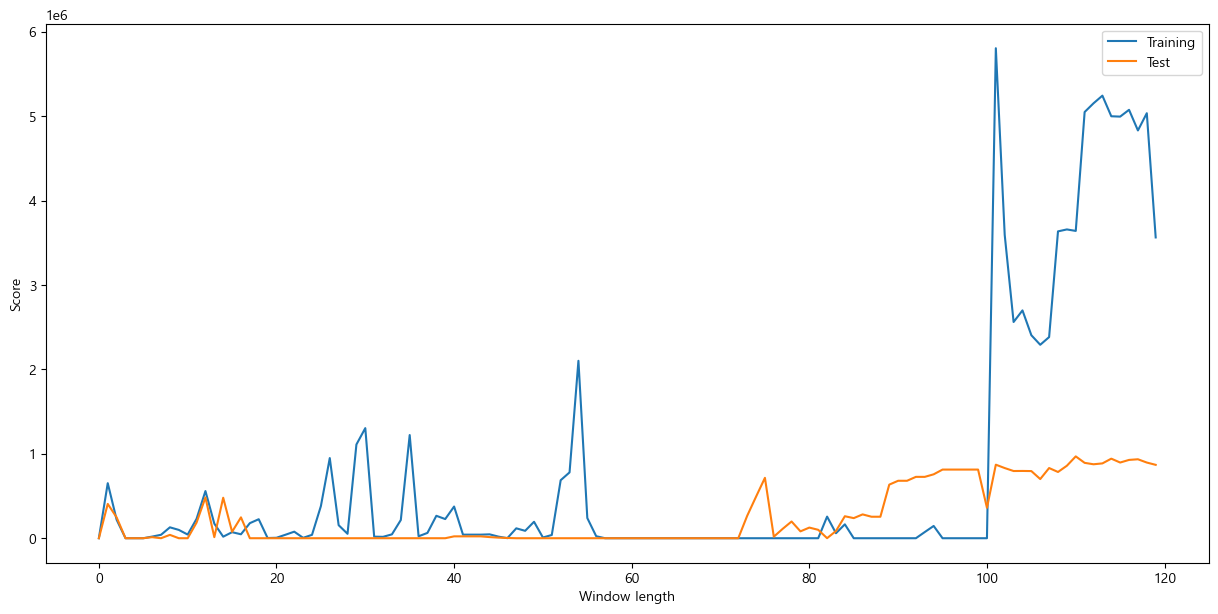

In [23]:
plt.figure(figsize=(15,7))
plt.plot(length_scores)
plt.plot(length_scores2)
plt.xlabel('Window length')
plt.ylabel('Score')
plt.legend(['Training', 'Test'])
plt.show()

- 그래프는 Train과 Test 데이터의 Window일수별 수익금액 시뮬레이션 결과
#### 둘다 높은 수익을 낼 것으로 예상되는 구간을 찾은 결과 해당 데이터에서는 100~120 사이가 비교적 합리적일 것으로 판단